# **<font color=white> 08.Random Forest Code 실습**

[목적]
  -  Decision Tree 실습 및 해석
  -  Variance를 낮추기위한 Bagging의 대표적인 모델 RandomForest 실습 및 해석

[Process]
  -  Define X's & Y
  -  Split Train & Valid dataset
  -  Modeling
  -  Model 해석

### 1. Decision Tree (의사 결정 트리)
정의:
Decision Tree는 분류와 회귀 문제에 사용되는 지도 학습 알고리즘이다. 데이터를 분석하여 이들 사이에 존재하는 패턴을 예측 가능한 규칙들의 조합으로 나타내며, 이 규칙들은 트리 구조로 표현된다.

특징:
- 해석이 용이: 트리의 시각화는 직관적이며 비전문가도 쉽게 이해할 수 있다.
데이터 전처리가 최소화: 트리 기반 알고리즘은 스케일링이나 정규화 같은 전처리가 필요 없다.
- 비선형 구분 가능: 선형 알고리즘과 달리 비선형 관계도 학습 가능하다.
- 과적합 문제: 트리의 깊이가 너무 깊어지면 특정 샘플에 지나치게 적응해 오버피팅될 수 있다.

### 2. Bagging & RandomForest (배깅 및 랜덤 포레스트)
Bagging (Bootstrap Aggregating):

Bagging은 고분산을 갖는 모델, 즉 과적합되기 쉬운 모델의 안정성을 증가시키기 위한 앙상블 기법이다.

- 작동 방식: 원래 훈련 데이터셋에서 여러 번 재추출(부트스트랩)하여 여러 개의 서브셋을 만든다. 이 서브셋들로 여러 모델을 독립적으로 학습시킨 후, 그 결과를 집계(투표 또는 평균)하여 최종 예측을 만든다.

RandomForest (랜덤 포레스트):

RandomForest는 Decision Tree의 Ensemble 방법 중 하나로, Bagging의 일종이다.

- 작동 방식: 여러 개의 Decision Tree를 만들어 투표 또는 평균을 통해 최종 예측을 한다. 각 트리는 부트스트랩된 데이터로 학습되며, 또한 각 노드에서 모든 특징을 고려하는 것이 아니라 무작위로 선택된 일부 특징만 고려된다.
- 장점: 단일 트리보다 오버피팅의 위험이 줄어들며, 높은 예측 성능을 제공한다. 또한, 특징 중요도도 제공하여 모델 해석에 도움을 준다.

정리:

RandomForest는 Bagging의 일반적인 개념을 사용하지만, 각 트리가 학습될 때 무작위로 선택된 특징의 일부만을 고려하여, 트리들 사이의 상관 관계를 줄이고 더 다양한 트리를 생성한다. 이러한 접근 방식은 더욱 강력한 앙상블을 형성하게 해준다.

In [1]:
import os
import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from collections import Counter
from sklearn import tree

In [2]:
# Data Loading (수술 時 사망 데이터)
data = pd.read_csv("https://raw.githubusercontent.com/GonieAhn/Data-Science-online-course-from-gonie/main/Data%20Store/example_data.csv")

In [3]:
data

,censor,event,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,gender,str2,strat,symptom,cd40,cd420,cd496,r,cd80,cd820
0,0,1090,43,66.679,0,1,0,100,0,1,...,1,1,3,0,504,353,660,1,870,782
1,1,794,31,73.030,0,1,0,100,0,1,...,1,1,3,0,244,225,106,1,708,699
2,0,957,41,66.226,0,1,1,100,0,1,...,1,1,3,0,401,366,453,1,889,720
3,1,188,35,78.019,0,1,0,100,0,1,...,1,1,3,0,221,132,-1,0,221,759
4,1,308,40,83.009,0,1,0,100,0,1,...,1,1,3,1,150,90,20,1,1730,1160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,0,1097,24,71.000,1,0,0,100,0,1,...,1,1,2,0,364,475,734,1,770,802
528,1,154,21,52.300,1,0,0,90,0,1,...,1,1,2,0,415,181,84,1,949,666
529,1,588,16,63.000,1,0,0,100,0,1,...,1,1,3,0,299,214,124,1,546,471
530,0,395,17,102.967,1,0,0,100,0,1,...,1,1,3,0,373,218,-1,0,1759,1030


[Data DESCR]

Brief Description

The original paper describing the trial is Hammer, S. M., Katzenstein, D. A., Hughes, M. D., Gundaker, H., Schooley, R. T., Haubrich, R. H., Henry, W. K., Lederman, M. M., Phair, J. P., Niu, M., Hirsch, M. S., and Merigan, T. C., for the Aids Clinical Trials Group Study 175 Study Team (1996). A trial comparing nucleoside monotherapy with combination therapy in HIV-infected adults with CD4 counts from 200 to 500 per cubic millimeter. The New England Journal of Medicine, 1081-1089.

Linear regression of response = cd4 count at 20 +- 5 weeks (cd420) was used in Tsiatis, A.A., Davidian, M., Zhang, M., and Lu, X. (2008), "Covariate adjustment for two-sample treatment comparisons in randomized clinical trials: A principled yet flexible approach," Statistics in Medicine.

Cox regression of response = time to death (event) was used in Lu X, Tsiatis AA (2008), "Improving the efficiency of the logrank test using auxiliary covariates," Biometrika.

In the text file above, the variables are named

- censor     :     censoring indicator = 1 if dead = 0 if censored
- event      :     event time
- age        :     age (yrs) at baseline
- wtkg       :     weight (kg) at baseline
- hemo       :     hemophilia (0=no, 1=yes)
- homo       :     homosexual activity (0=no, 1=yes)
- drugs      :     history of IV drug use (0=no, 1=yes)
- karnof     :     Karnofsky score (on a scale of 0-100)
- oprior     :     Non-ZDV antiretroviral therapy pre-175 (0=no, 1=yes)
- z30        :     ZDV in the 30 days prior to 175 (0=no, 1=yes)
- zprior     :     ZDV prior to 175 (0=no, 1=yes)
- preanti    :     # days pre-175 anti-retroviral therapy
- race       :     race (0=White, 1=non-white)
- gender     :     gender (0=F, 1=M)
- str2       :     antiretroviral history (0=naive, 1=experienced)
- strat      :     antiretroviral history stratification (1='Antiretroviral Naive',2='> 1 but <= 52 weeks of prior antiretroviral therapy',3='> 52 weeks)
- symptom    :     symptomatic indicator (0=asymp, 1=symp)
- cd40       :     baseline cd4
- cd420      :     cd4 count at 20 +- 5 weeks
- cd496      :     cd4 count at 96 +- 5 weeks (missing for a lot of subjects)
- r          :     missingness indicator for cd496
- cd80       :     baseline cd8 count
- cd820      :     cd8 count at 20 +- 5 weeks

[데이터 설명]

간단한 설명

해당 연구를 기술한 원래의 논문은 Hammer, S. M., Katzenstein, D. A., Hughes, M. D., Gundaker, H., Schooley, R. T., Haubrich, R. H., Henry, W. K., Lederman, M. M., Phair, J. P., Niu, M., Hirsch, M. S., 그리고 Merigan, T. C. 등에 의해 작성되었습니다. (1996). HIV 감염 성인에서의 CD4 개수가 백밀리미터당 200에서 500 사이일 때의 뉴클레오사이드 단일 치료와 병합 치료를 비교한 시험. The New England Journal of Medicine, 1081-1089.

Tsiatis, A.A., Davidian, M., Zhang, M., 그리고 Lu, X. (2008)에서는 반응 = 20주 +- 5주의 cd4 개수 (cd420)에 대한 선형 회귀를 사용하였습니다. "랜덤화된 임상 시험에서 두 표본 치료 비교를 위한 공변량 조정: 원칙적이면서도 유연한 접근법," Statistics in Medicine.

Lu X, Tsiatis AA (2008)에서는 반응 = 사망 시간 (event)에 대한 Cox 회귀를 사용하였습니다. "보조 공변량을 사용하여 logrank 검정의 효율성 향상," Biometrika.

위의 텍스트 파일에서 변수는 다음과 같이 이름이 지어져 있습니다:

- censor: 검열 지표 = 1은 사망, 0은 검열을 의미
- event: 사건 시간
- age: 기준 시점의 나이
- wtkg: 기준 시점의 몸무게 (kg)
- hemo: 혈우병 (0=아니오, 1=예)
- homo: 동성애 행위 (0=아니오, 1=예)
- drugs: IV 약물 사용력 (0=아니오, 1=예)
- karnof: Karnofsky 점수 (0-100의 척도)
- oprior: 175 전의 비-ZDV 항레트로 바이러스 치료 (0=아니오, 1=예)
- z30: 175 전 30일 동안의 ZDV (0=아니오, 1=예)
- zprior: 175 전 ZDV (0=아니오, 1=예)
- preanti: 175 전 항레트로 바이러스 치료 일수
- race: 인종 (0=백인, 1=비백인)
- gender: 성별 (0=여성, 1=남성)
- str2: 항레트로 바이러스 치료력 (0=경험이 없음, 1=경험이 있음)
- strat: 항레트로 바이러스 치료력 계층화 (1='항레트로 바이러스 치료 미경험',2='이전 항레트로 바이러스 치료 > 1주 지만 <= 52주',3='> 52주)
- symptom: 증상 지표 (0=무증상, 1=유증상)
- cd40: 기준 cd4 개수
- cd420: 20주 +- 5주의 cd4 개수
- cd496: 96주 +- 5주의 cd4 개수 (많은 대상자에게 누락됨)
- r: cd496의 누락 지표
- cd80: 기준 cd8 개수
- cd820: 20주 +- 5주의 cd8 개수

In [4]:
data.shape[1]

23

In [6]:
data.describe()

,censor,event,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,gender,str2,strat,symptom,cd40,cd420,cd496,r,cd80,cd820
count,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,...,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000,532.000000
mean,0.340226,801.236842,35.225564,76.061855,0.078947,0.640977,0.118421,95.432331,0.030075,0.546992,...,0.812030,0.580827,1.981203,0.167293,353.204887,336.139098,173.146617,0.603383,987.250000,928.214286
std,0.474231,326.887929,8.852094,13.224698,0.269910,0.480165,0.323410,5.981856,0.170955,0.498255,...,0.391056,0.493888,0.905946,0.373589,114.105253,130.961573,191.455406,0.489656,475.223907,438.569798
min,0.000000,33.000000,13.000000,47.401000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,103.000000,49.000000,-1.000000,0.000000,221.000000,150.000000
25%,0.000000,535.750000,29.000000,67.500000,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,271.000000,243.750000,-1.000000,0.000000,653.250000,626.500000
50%,0.000000,933.500000,34.000000,74.600000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,2.000000,0.000000,346.000000,330.500000,113.000000,1.000000,881.000000,818.000000
75%,1.000000,1081.000000,40.000000,83.502000,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,1.000000,3.000000,0.000000,422.000000,418.000000,324.000000,1.000000,1190.000000,1164.000000
max,1.000000,1231.000000,70.000000,149.000000,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,...,1.000000,1.000000,3.000000,1.000000,771.000000,909.000000,857.000000,1.000000,4255.000000,3130.000000


[ISSUE]
 - Tree 계열은 Scaling이 필요한가?

In [7]:
# Label Balace Check - lmbalance
Counter(data['censor'])

Counter({0: 351, 1: 181})

In [8]:
# X's & Y Split
Y = data['censor']
X = data.drop(columns=['censor'])

In [9]:
data.shape

(532, 23)

In [10]:
X.shape

(532, 22)

In [11]:
Y.shape

(532,)

- 여기에서 드는 의문 회귀문제에서는 Counter을 안썻는데 분류에는 Counter을 쓰는 이유가 있을까?
- 여기에서 Counter을 쓰는 이유는 label이 0과 1로 나누어진 이진 분류이기 때문이다. 그래서 각각의 분포가 어떻게 되는지 확ㅇ니하기 위해서 사용하는 Counter을 사용하는 것이다.

In [12]:
idx = list(range(X.shape[0]))
train_idx, valid_idx = train_test_split(idx, test_size=0.3, random_state=2023)
print(">>>> # of Train data : {}".format(len(train_idx)))
print(">>>> # of valid data : {}".format(len(valid_idx)))
print(">>>> # of Train data Y : {}".format(Counter(Y.iloc[train_idx])))
print(">>>> # of valid data Y : {}".format(Counter(Y.iloc[valid_idx])))

>>>> # of Train data : 372
>>>> # of valid data : 160
>>>> # of Train data Y : Counter({0: 250, 1: 122})
>>>> # of valid data Y : Counter({0: 101, 1: 59})


[Decision Tree를 활용한 Rule Extraction]

 - Max_Depth는 5 초과를 넘지 않아야함, 5를 초과하게 되면 Rule Extraction Plotting의 가독성이 매우 떨어짐
 - 정확도와 설명력은 Trade-off가 존재하기 때문에 자기만의 기준으로 적절한 선을 선택하면 됨
 - Rule Extraction 할때 GINI INDEX 뿐만 아니라 Sample 개수도 중요한 척도가 됨
GINI INDEX가 아주 낮지만(불순도가 낮음, 좋음) Sample의 개수가 너무 적으면 의미가 없음(Overfitting이라고 생각됨)

**지니 계수 (Gini Coefficient)**는 경제학과 통계학에서 사용되는 지표로서, 어떤 분포의 불평등을 측정하는 데 사용됩니다. 여기에서는 주로 경제학 관점에서의 지니 계수에 대해 설명하겠습니다.

정의:
지니 계수는 0과 1 사이의 값을 가지며, 0은 완전한 평등을 나타내고 (모든 개체가 동일한 값을 가질 때) 1은 완전한 불평등을 나타냅니다 (한 개체만이 모든 자원을 가지고 나머지는 아무것도 가지지 않을 때).

계산 방법:
지니 계수는 Lorenz Curve와 45도 선 사이의 영역의 두 배로 계산됩니다. Lorenz Curve는 어떤 분포의 누적 백분율을 그래프로 표시한 것이며, 45도 선은 완전한 평등을 나타내는 선입니다.

경제학에서의 의미:
지니 계수는 주로 소득 또는 부의 분평등을 측정하는 데 사용됩니다. 예를 들어, 한 나라의 지니 계수가 0.4라면, 그 나라의 소득 분포나 부의 분포에 불평등이 있다는 것을 나타냅니다.

데이터 과학에서의 의미:
지니 계수는 결정 트리나 랜덤 포레스트와 같은 트리 기반 알고리즘에서 불순도(impurity)나 분기 기준을 평가할 때 사용되기도 합니다. 클래스의 혼합도를 측정하는 지표로 사용되며, 지니 불순도가 높을수록 분류가 혼합된 상태를 나타냅니다.

장점과 단점:

장점: 지니 계수는 직관적이며 계산이 비교적 간단하다.
단점: 다양한 소득 또는 부 분포에 대해 동일한 지니 계수 값을 가질 수 있기 때문에, 분포의 모양이나 특성에 대한 구체적인 정보를 제공하지 않을 수 있습니다.
기타 정보:
지니 계수는 세계 은행, 유엔 등 다양한 국제 기구에서 각 나라의 소득 불평등을 비교하거나 추적하는 데 사용되며, 소득 불평등의 정도를 판단하는 중요한 지표 중 하나입니다.

In [15]:
# Depth 조절 Decision Tree
for i in range(2,11,1):
    print(">>>> Depth {}".format(i))

    model = DecisionTreeClassifier(max_depth=i, criterion='gini')
    model.fit(X.iloc[train_idx], Y.iloc[train_idx])

    # Train Acc
    y_pre_train = model.predict(X.iloc[train_idx])
    cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
    print("Train Confusion Matrix")
    print(cm_train)
    print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
    print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

    # Test Acc
    y_pre_test = model.predict(X.iloc[valid_idx])
    cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
    print("Train Confusion Matrix")
    print(cm_test)
    print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
    print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))
    print("-----------------------------------------------------------------------")
    print("-----------------------------------------------------------------------")

>>>> Depth 2
Train Confusion Matrix
[[241   9]
 [ 44  78]]
Train Acc : 0.8575268817204301
Train F1-Score : 0.7464114832535885
Train Confusion Matrix
[[97  4]
 [26 33]]
TesT Acc : 0.8125
Test F1-Score : 0.6874999999999999
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>>> Depth 3
Train Confusion Matrix
[[228  22]
 [ 18 104]]
Train Acc : 0.8924731182795699
Train F1-Score : 0.8387096774193549
Train Confusion Matrix
[[87 14]
 [13 46]]
TesT Acc : 0.83125
Test F1-Score : 0.773109243697479
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>>> Depth 4
Train Confusion Matrix
[[227  23]
 [ 10 112]]
Train Acc : 0.9112903225806451
Train F1-Score : 0.8715953307392996
Train Confusion Matrix
[[90 11]
 [11 48]]
TesT Acc : 0.8625
Test F1-Score : 0.8135593220338985
-------------------------------------------------

In [17]:
# Depth가 깊어질 수록 정확도는 높게 나오지만 해석력에 대한 가독성을 위해 Depth 5를 선택함
model = DecisionTreeClassifier(max_depth=4, criterion='gini')
model.fit(X.iloc[train_idx], Y.iloc[train_idx])

DecisionTreeClassifier(max_depth=4)

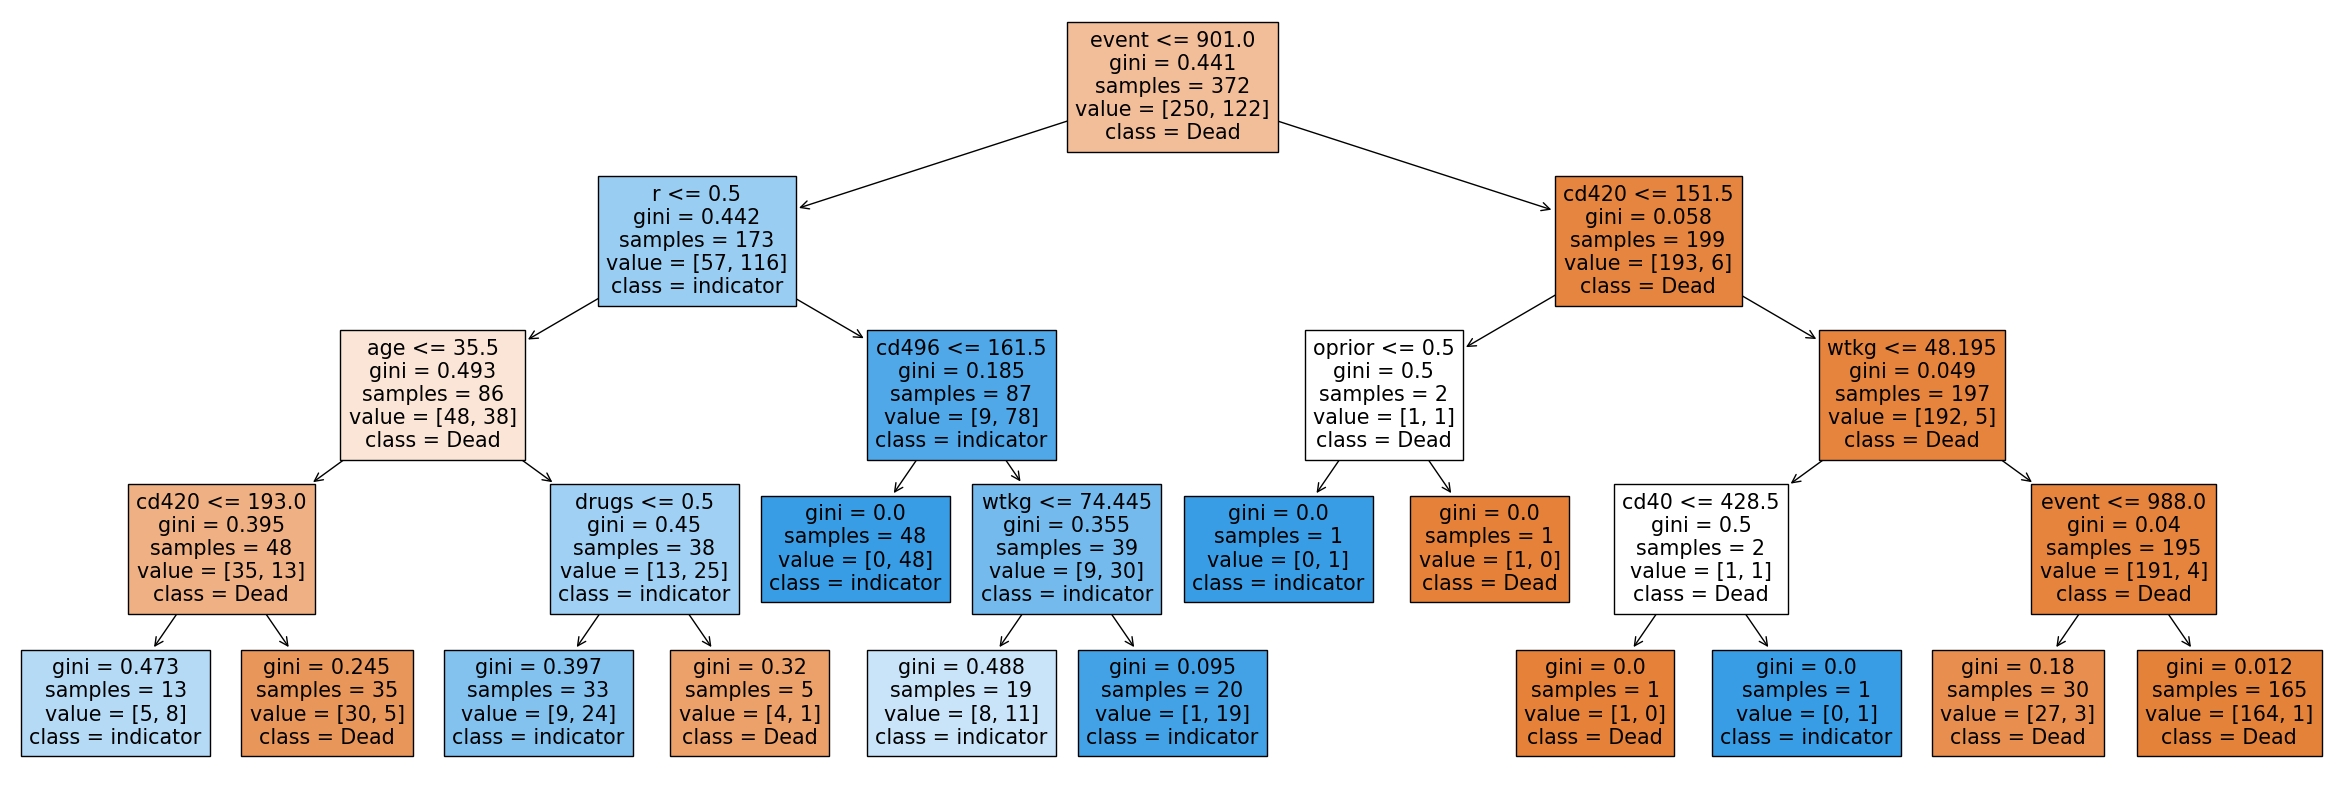

In [19]:
# Creating the tree plot
tree.plot_tree(model, filled=True, feature_names=X.columns, class_names = ['Dead', 'indicator'])
plt.rcParams['figure.figsize'] = [30,10]

- 루트 노드 (Root Node): 맨 위에 위치한 노드로, 데이터셋의 전체 데이터를 나타냅니다.
- 분기 노드 (Internal Node): 특정 조건에 따라 데이터를 분할하는 노드입니다.
- 리프 노드 (Leaf Node): 더 이상 분할할 수 없는 노드로, 결정나무의 최종 결정(예측)을 나타냅니다.

각 노드에는 다음과 같은 정보가 포함될 수 있습니다:

분할 조건 (예:
�
≤
5.5
x≤5.5)
노드의 샘플 수 (예: samples = 100)
각 클래스의 샘플 수 (예: value = [50, 50])
예측된 클래스 (만약 리프 노드라면)
이러한 정보를 통해 데이터가 어떻게 분할되는지, 어느 조건에서 어떤 결정을 내리는지 파악할 수 있습니다.



[Random Forest]

 - Hyperparameter tuning
 - estimators, depth
 - Random Forest는 이 두개만 조절해도 좋은 결과를 얻을 수 있음
 - GridSearchCV를 사용하지 않고 For Loop를 돌리는 이유
    - 내가 원하는 결과를 저장하고 Display 하고 싶음
    - 내가 원하는 결과를 실시간 Display 하면서 그때 그때 파라미터 튜닝에 대한 대처를 하고 싶음

[Random Forest Parameters]
  - Package : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
  - n_estimators : # of Tree
  - criterion : Measuring for Split (Information gain)
     - Gini
     - entropy
     - log_loss
  - max_depth : Tree의 최대 깊이 제한
  - min_samples_split : 2개로 Split 하는게 아니라 N개로 Split 가능
  - bootstrap : Bagging 중 Boostrap 기법
  - max_features : Feature 수 sampling
     - auto
     - sqrt
     - log2
  - oob_score : out-of-bag Score
  - class_weight : Label Imbalance 데이터 학습시 weight를 주는 것
     - {0: 1, 1: 1}
  - random_state : Two way Random Choosen 때문에 매 결과가 달라짐
     - 지정한 값으로 해주는 것이 결과가 같아짐

In [20]:
# RandomForest Hyperparameter
estimators = [10, 30, 40, 50, 60]
depth = [4 , 5, 10, 15]

# Modeling
save_est = []
save_dep = []
f1_score_ = []

cnt = 0
for est in estimators:
    for dep in depth:
        print(">>> {} <<<".format(cnt))
        cnt += 1
        print("Number of Estimators : {}, Max Depth : {}".format(est, dep))

        model = RandomForestClassifier(n_estimators=est, max_depth=dep, random_state=119,
                                       criterion='gini', max_features='auto',
                                       bootstrap=True, oob_score=False) # if you use "oob_score=True", get long time for training
        model.fit(X.iloc[train_idx], Y.iloc[train_idx])

        # Train Acc
        y_pre_train = model.predict(X.iloc[train_idx])
        cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
        print("Train Confusion Matrix")
        print(cm_train)
        print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
        print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

        # Test Acc
        y_pre_test = model.predict(X.iloc[valid_idx])
        cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
        print("Test Confusion Matrix")
        print(cm_test)
        print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
        print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))
        print("-----------------------------------------------------------------------")
        print("-----------------------------------------------------------------------")
        save_est.append(est)
        save_dep.append(dep)
        f1_score_.append(f1_score(Y.iloc[valid_idx], y_pre_test))

>>> 0 <<<
Number of Estimators : 10, Max Depth : 4
Train Confusion Matrix
[[242   8]
 [ 29  93]]
Train Acc : 0.9005376344086021
Train F1-Score : 0.8340807174887892
Test Confusion Matrix
[[93  8]
 [26 33]]
TesT Acc : 0.7875
Test F1-Score : 0.6599999999999999
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 1 <<<
Number of Estimators : 10, Max Depth : 5
Train Confusion Matrix
[[243   7]
 [ 14 108]]
Train Acc : 0.9435483870967742
Train F1-Score : 0.9113924050632911
Test Confusion Matrix
[[90 11]
 [23 36]]
TesT Acc : 0.7875
Test F1-Score : 0.679245283018868
-----------------------------------------------------------------------
-----------------------------------------------------------------------
>>> 2 <<<
Number of Estimators : 10, Max Depth : 10
Train Confusion Matrix
[[249   1]
 [  3 119]]
Train Acc : 0.989247311827957
Train F1-Score : 0.9834710743801653
Test Confusion Matrix
[[93  8]
 [

- append에 save_est, save_dep를 저장한다음dp argmax를 사용하여 문제를 해결함

In [21]:
# Best Model
best_model = RandomForestClassifier(n_estimators=save_est[np.argmax(f1_score_)], max_depth=save_dep[np.argmax(f1_score_)], random_state=119,
                               criterion='gini', max_features='auto',
                               bootstrap=True, oob_score=False) # if you use "oob_score=True", get long time for training
best_model.fit(X.iloc[train_idx], Y.iloc[train_idx])

RandomForestClassifier(max_depth=10, max_features='auto', n_estimators=40,
                       random_state=119)

In [22]:
# Train Acc
y_pre_train = best_model.predict(X.iloc[train_idx])
cm_train = confusion_matrix(Y.iloc[train_idx], y_pre_train)
print("Train Confusion Matrix")
print(cm_train)
print("Train Acc : {}".format((cm_train[0,0] + cm_train[1,1])/cm_train.sum()))
print("Train F1-Score : {}".format(f1_score(Y.iloc[train_idx], y_pre_train)))

# Test Acc
y_pre_test = best_model.predict(X.iloc[valid_idx])
cm_test = confusion_matrix(Y.iloc[valid_idx], y_pre_test)
print("Test Confusion Matrix")
print(cm_test)
print("TesT Acc : {}".format((cm_test[0,0] + cm_test[1,1])/cm_test.sum()))
print("Test F1-Score : {}".format(f1_score(Y.iloc[valid_idx], y_pre_test)))

Train Confusion Matrix
[[250   0]
 [  0 122]]
Train Acc : 1.0
Train F1-Score : 1.0
Test Confusion Matrix
[[93  8]
 [12 47]]
TesT Acc : 0.875
Test F1-Score : 0.8245614035087718


In [23]:
feature_map = pd.DataFrame(sorted(zip(best_model.feature_importances_, X.columns), reverse=True), columns=['Score', 'Feature'])
print(feature_map)

       Score  Feature
0   0.325071    event
1   0.116611    cd420
2   0.080297    cd496
3   0.068333     cd80
4   0.066404     wtkg
5   0.064655    cd820
6   0.062691     cd40
7   0.054047      age
8   0.047875  preanti
9   0.036185        r
10  0.013194   karnof
11  0.011671    strat
12  0.011409     race
13  0.006760    drugs
14  0.006678   gender
15  0.006291     hemo
16  0.006121     homo
17  0.005438  symptom
18  0.005390      z30
19  0.004878     str2
20  0.000000   zprior
21  0.000000   oprior


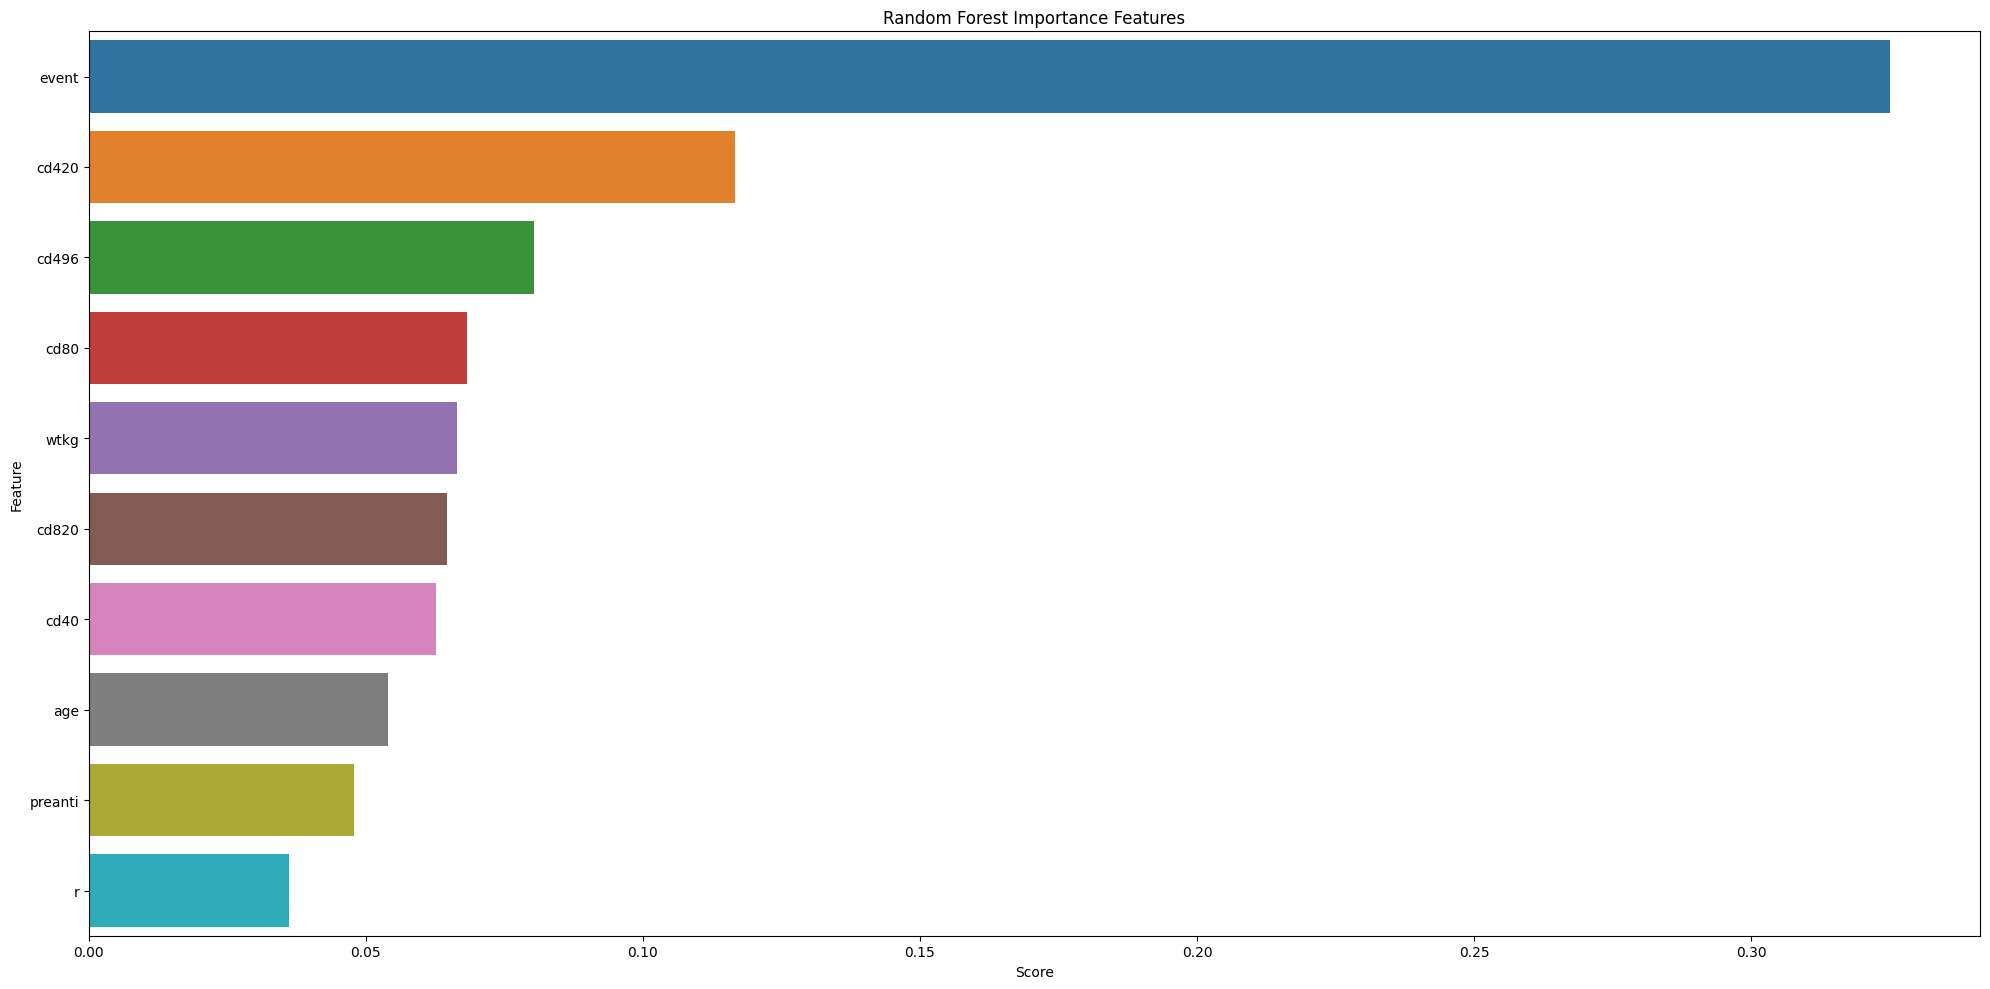

In [24]:
# Importance Score Top 10
feature_map_20 = feature_map.iloc[:10]
plt.figure(figsize=(20, 10))
sns.barplot(x="Score", y="Feature", data=feature_map_20.sort_values(by="Score", ascending=False), errwidth=40)
plt.title('Random Forest Importance Features')
plt.tight_layout()
plt.show()